In [1]:
import math

import IPython
import IPython.display
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import auxiliaries as aux

## Setup

In [2]:
# Develop window for data separation
species = 'Deer'
file_name = 'GSM02927'

years_to_predict = 1
time_intervals = 3 if species == 'Moose' else 4

regressive_window = aux.RegressiveWindow(species, file_name)
reversed_regressive_window = aux.ReversedRegressiveWindow(species, file_name)

results = {}

print('------Original Regressive Window------')
print(f'Original Data Size: {len(regressive_window.orig_df)}')
print(f'Training Data Size: {len(regressive_window.train_df)}')
print(f'Testing Data Size: {len(regressive_window.test_df)}\n')

print(f'Training Mean:\n{regressive_window.train_df.mean()}')
print(f'Training Std. Dev.:\n{regressive_window.train_df.std()}\n')

print('------Reversed Regressive Window------')
print(f'Original Data Size: {len(reversed_regressive_window.orig_df)}')
print(f'Training Data Size: {len(reversed_regressive_window.train_df)}')
print(f'Testing Data Size: {len(reversed_regressive_window.test_df)}\n')

print(f'Training Mean:\n{reversed_regressive_window.train_df.mean()}')
print(f'Training Std. Dev.:\n{reversed_regressive_window.train_df.std()}\n')

------Original Regressive Window------
Original Data Size: 2923
Training Data Size: 2046
Testing Data Size: 877

Training Mean:
external-temperature    16.545455
longitude               11.031551
latitude                46.008411
month                    6.251222
day                     15.697458
dtype: float64
Training Std. Dev.:
external-temperature    5.343885
longitude               0.021036
latitude                0.002235
month                   3.396595
day                     8.695606
dtype: float64

------Reversed Regressive Window------
Original Data Size: 2923
Training Data Size: 2046
Testing Data Size: 877

Training Mean:
external-temperature    15.382209
longitude               11.036021
latitude                46.008706
month                    6.727273
day                     15.601173
dtype: float64
Training Std. Dev.:
external-temperature    6.524474
longitude               0.018820
latitude                0.002072
month                   3.458438
day                  

### Regressive Model

In [3]:
regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1,3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

regressive_window.model_compilation_and_fitting(regressive_model)

c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7710 - mean_absolute_error: 0.7229 - mean_squared_error: 0.7710
Epoch 2/20
40/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5554 - mean_absolute_error: 0.5636 - mean_squared_error: 0.5554

c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  current = self.get_monitor_value(logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5541 - mean_absolute_error: 0.5598 - mean_squared_error: 0.5541
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4872 - mean_absolute_error: 0.5114 - mean_squared_error: 0.4872
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4526 - mean_absolute_error: 0.4880 - mean_squared_error: 0.4526
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4478 - mean_absolute_error: 0.4840 - mean_squared_error: 0.4478
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4547 - mean_absolute_error: 0.4803 - mean_squared_error: 0.4547
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4361 - mean_absolute_error: 0.4683 - mean_squared_error: 0.4361
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4160 - mean_absolute_error: 0.4524 - mean_squared_error: 0.4160
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3975 - mean_absolute_error: 0.4362 - mean_squared_error: 0.3975
Epoch 10/20
64/64 ━

In [4]:
results['Original Regressive Model'] = regressive_model.evaluate(regressive_window.test_input, regressive_window.test_label, verbose=1, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0711 - mean_absolute_error: 0.7665 - mean_squared_error: 1.0711  


In [5]:
# Input ordering
original_output = regressive_window.test_label
original_output = original_output.reshape((original_output.shape[0], original_output.shape[-1]))
predicted_output = regressive_model(regressive_window.test_input).numpy()
predicted_output = predicted_output.reshape((predicted_output.shape[0], predicted_output.shape[-1]))

# Statistics gathering
mae_values = list(mean_absolute_error(original_output, predicted_output, multioutput='raw_values'))
mae_values = {coord_name: coord_value for coord_name, coord_value in zip(['mae_longitude', 'mae_latitude'], mae_values)}

mse_values = list(mean_squared_error(original_output, predicted_output, multioutput='raw_values'))
mse_values = {coord_name: coord_value for coord_name, coord_value in zip(['mse_longitude', 'mse_latitude'], mse_values)}

# Apply statistics to results
results['Original Regressive Model'].update(mae_values)
results['Original Regressive Model'].update(mse_values)

In [6]:
results

{'Original Regressive Model': {'loss': 0.8874377608299255,
  'mean_absolute_error': 0.7207131385803223,
  'mean_squared_error': 0.8874377608299255,
  'mae_longitude': 0.7361759611671084,
  'mae_latitude': 0.7052501407429674,
  'mse_longitude': 0.9618408933261644,
  'mse_latitude': 0.8130347825762871}}

In [7]:
# Histogram for Distance Errors
distances = []
unnormed_original_output = original_output*regressive_window.train_df[['longitude', 'latitude']].std().values + regressive_window.train_df[['longitude', 'latitude']].mean().values
unnormed_predicted_output = predicted_output*regressive_window.train_df[['longitude', 'latitude']].std().values + regressive_window.train_df[['longitude', 'latitude']].mean().values

r = 3958.756 + 636/5280 # Average radius of Earth to sea level plus elevation of Trentino
for original_coord, predicted_coord in zip(unnormed_original_output, unnormed_predicted_output):
    curr_d = 2*r*math.asin(
        math.sqrt(
            ((1-math.cos(math.radians(predicted_coord[1] - original_coord[1]))) 
             + math.cos(math.radians(predicted_coord[1]))*math.cos(math.radians(original_coord[1]))*(1-math.cos(math.radians(predicted_coord[0] - original_coord[0]))))/2))
    distances.append(curr_d)

In [8]:
hist, bins = np.histogram(distances, bins=12, range=(0, 3), density=True)

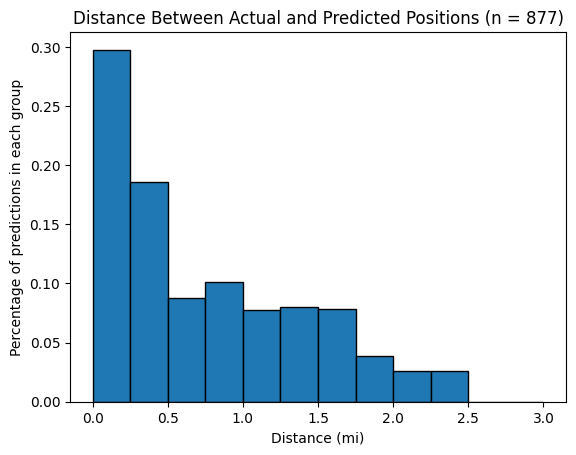

In [9]:
# Histogram of distances
con = plt.bar(bins[0:len(bins) - 1] + 0.125, hist*0.25, edgecolor='black', width=0.25)
plt.title(f"Distance Between Actual and Predicted Positions (n = {len(distances)})")
plt.xlabel("Distance (mi)")
plt.ylabel("Percentage of predictions in each group")
plt.show()

In [10]:
pd.DataFrame(distances, columns=['Distances']).describe()

,Distances
count,877.000000
mean,0.765528
std,0.643484
min,0.003331
25%,0.213699
50%,0.545646
75%,1.225037
max,2.496089


In [11]:
regressive_window.csv_extension(f'{species}/{file_name}_regressive', species, regressive_model)

In [12]:
regressive_model.save(f'ModelFiles/SavedModels/{species}/{file_name}_regressive.keras')

In [13]:
# Generate CSV file analyzing testing set results
def graph_regressive(model, window, url_dest):
    test_df = window.test_df
    test_df['timestamp'] = window.timeline[int(len(window.orig_df)*0.7):]

    initial_df = test_df[['timestamp', 'month', 'day', 'external-temperature', 'longitude', 'latitude']]
    initial_df['id'] = ['original' for _ in range(len(initial_df))]

    data = {
        'timestamp': [],
        'month': [],
        'day': [],
        'external-temperature': [],
        'longitude': [],
        'latitude': [],
        'id': []
    }

    for i in range(len(initial_df)):
        section = initial_df.iloc[i]

        timestamp = section['timestamp']
        month = (section['month'] - window.train_df['month'].mean())/window.train_df['month'].std()
        day = (section['day'] - window.train_df['day'].mean())/window.train_df['day'].std()
        external_temp = (section['external-temperature'] - window.train_df['external-temperature'].mean())/window.train_df['external-temperature'].std()

        if isinstance(model, tf.keras.Sequential):
            output_fields = model(np.array([external_temp, month, day]).reshape([1, 1, 3])).numpy()*window.train_df[['longitude', 'latitude']].std().values + window.train_df[['longitude', 'latitude']].mean().values
            output_fields = output_fields[0][0]
        elif isinstance(model, sklearn.neighbors.KNeighborsRegressor):
            output_fields = model.predict([[external_temp, month, day]])[0]*window.train_df[['longitude', 'latitude']].std() + window.train_df[['longitude', 'latitude']].mean()
            output_fields = output_fields.values

        longitude = output_fields[0]
        latitude = output_fields[1]
        id = 'predicted'

        data['timestamp'].append(timestamp)
        data['month'].append(section['month'])
        data['day'].append(section['day'])
        data['external-temperature'].append(section['external-temperature'])
        data['longitude'].append(longitude)
        data['latitude'].append(latitude)
        data['id'].append(id)

    add_on_df = pd.DataFrame(data)
    
    full_df = pd.concat([initial_df, add_on_df], ignore_index=True)
    full_df.to_csv(url_dest, index=False)

    return full_df

graph_regressive(regressive_model, regressive_window, f'CSVFiles/TestPerformanceCSV/{species}/{file_name}_regressive_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_25904\3778714951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['timestamp'] = window.timeline[int(len(window.orig_df)*0.7):]
C:\Users\Imper\AppData\Local\Temp\ipykernel_25904\3778714951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df['id'] = ['original' for _ in range(len(initial_df))]


,timestamp,month,day,external-temperature,longitude,latitude,id
0,2007-10-19 16:02:55,10,19,-0.6,11.047242,46.010533,original
1,2007-10-19 20:01:47,10,19,-3.6,11.048442,46.008974,original
2,2007-10-20 00:01:11,10,20,11.4,11.047115,46.009779,original
3,2007-10-20 04:00:55,10,20,-7.3,11.048017,46.008876,original
4,2007-10-20 08:00:55,10,20,-8.0,11.046749,46.009134,original
...,...,...,...,...,...,...,...
1749,2008-03-14 16:00:54,3,14,4.4,11.041203,46.011711,predicted
1750,2008-03-14 20:01:53,3,14,4.7,11.041498,46.011743,predicted
1751,2008-03-15 00:03:05,3,15,3.8,11.038999,46.011614,predicted
1752,2008-03-15 04:02:21,3,15,1.0,11.035604,46.011227,predicted


### Reveresed Regressive

In [14]:
reversed_regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1,3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

reversed_regressive_window.model_compilation_and_fitting(reversed_regressive_model)

c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6915 - mean_absolute_error: 0.6322 - mean_squared_error: 0.6915
Epoch 2/20
29/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5555 - mean_absolute_error: 0.5301 - mean_squared_error: 0.5555

c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  current = self.get_monitor_value(logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5416 - mean_absolute_error: 0.5232 - mean_squared_error: 0.5416
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5111 - mean_absolute_error: 0.4978 - mean_squared_error: 0.5111
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4844 - mean_absolute_error: 0.4775 - mean_squared_error: 0.4844
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4485 - mean_absolute_error: 0.4706 - mean_squared_error: 0.4485
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4285 - mean_absolute_error: 0.4490 - mean_squared_error: 0.4285
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4165 - mean_absolute_error: 0.4419 - mean_squared_error: 0.4165
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3967 - mean_absolute_error: 0.4284 - mean_squared_error: 0.3967
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4212 - mean_absolute_error: 0.4403 - mean_squared_error: 0.4212
Epoch 10/20
64/64 ━

In [15]:
results['Reversed Regressive Model'] = reversed_regressive_model.evaluate(reversed_regressive_window.test_input, reversed_regressive_window.test_label, verbose=1, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3473 - mean_absolute_error: 1.2510 - mean_squared_error: 2.3473  


In [16]:
# Input ordering
reversed_original_output = reversed_regressive_window.test_label
reversed_original_output = reversed_original_output.reshape((reversed_original_output.shape[0], reversed_original_output.shape[-1]))
reversed_predicted_output = reversed_regressive_model(reversed_regressive_window.test_input).numpy()
reversed_predicted_output = reversed_predicted_output.reshape((reversed_predicted_output.shape[0], reversed_predicted_output.shape[-1]))

# Statistics gathering
mae_values = list(mean_absolute_error(reversed_original_output, reversed_predicted_output, multioutput='raw_values'))
mae_values = {coord_name: coord_value for coord_name, coord_value in zip(['mae_longitude', 'mae_latitude'], mae_values)}

mse_values = list(mean_squared_error(reversed_original_output, reversed_predicted_output, multioutput='raw_values'))
mse_values = {coord_name: coord_value for coord_name, coord_value in zip(['mse_longitude', 'mse_latitude'], mse_values)}

# Apply statistics to results
results['Reversed Regressive Model'].update(mae_values)
results['Reversed Regressive Model'].update(mse_values)

In [17]:
results['Reversed Regressive Model']

{'loss': 2.1729726791381836,
 'mean_absolute_error': 1.1391651630401611,
 'mean_squared_error': 2.1729726791381836,
 'mae_longitude': 0.9172500872313643,
 'mae_latitude': 1.3610804562512886,
 'mse_longitude': 1.6814117354995344,
 'mse_latitude': 2.664533107548024}

In [18]:
# Histogram for Distance Errors
reversed_distances = []
unnormed_reversed_original_output = reversed_original_output*reversed_regressive_window.train_df[['longitude', 'latitude']].std().values + reversed_regressive_window.train_df[['longitude', 'latitude']].mean().values
unnormed_reversed_predicted_output = reversed_predicted_output*reversed_regressive_window.train_df[['longitude', 'latitude']].std().values + reversed_regressive_window.train_df[['longitude', 'latitude']].mean().values

r = 3958.756 + 636/5280 # Average radius of Earth to sea level plus elevation of Trentino
for original_coord, predicted_coord in zip(unnormed_reversed_original_output, unnormed_reversed_predicted_output):
    curr_d = 2*r*math.asin(
        math.sqrt(
            ((1-math.cos(math.radians(predicted_coord[1] - original_coord[1]))) 
             + math.cos(math.radians(predicted_coord[1]))*math.cos(math.radians(original_coord[1]))*(1-math.cos(math.radians(predicted_coord[0] - original_coord[0]))))/2))
    reversed_distances.append(curr_d)

In [19]:
hist, bins = np.histogram(reversed_distances, bins=12, range=(0,3), density=True)

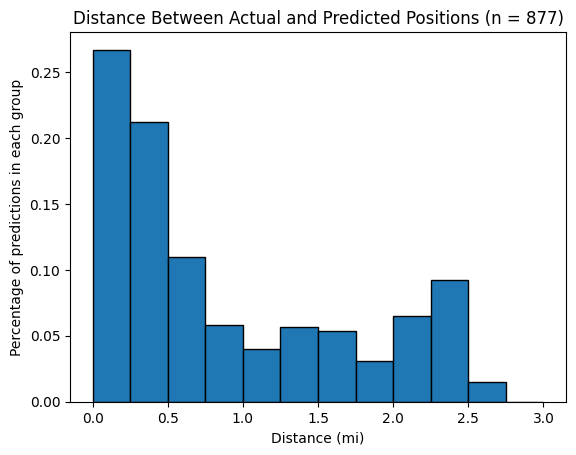

In [20]:
# Histogram of distances
con = plt.bar(bins[0:len(bins) - 1] + 0.125, hist*0.25, edgecolor='black', width=0.25)
plt.title(f"Distance Between Actual and Predicted Positions (n = {len(reversed_distances)})")
plt.xlabel("Distance (mi)")
plt.ylabel("Percentage of predictions in each group")
plt.show()

In [21]:
pd.DataFrame(reversed_distances, columns=['Distances']).describe()

,Distances
count,877.000000
mean,0.894687
std,0.791402
min,0.021877
25%,0.230925
50%,0.542375
75%,1.517084
max,2.667279


In [22]:
reversed_regressive_window.csv_extension(f'{species}/{file_name}_reversed_regressive', species, reversed_regressive_model)

In [23]:
reversed_regressive_model.save(f'ModelFiles/SavedModels/{species}/{file_name}_reversed_regressive.keras')

In [24]:
graph_regressive(reversed_regressive_model, reversed_regressive_window, f'CSVFiles/TestPerformanceCSV/{species}/{file_name}_reversed_regressive_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_25904\3778714951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['timestamp'] = window.timeline[int(len(window.orig_df)*0.7):]
C:\Users\Imper\AppData\Local\Temp\ipykernel_25904\3778714951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df['id'] = ['original' for _ in range(len(initial_df))]


,timestamp,month,day,external-temperature,longitude,latitude,id
0,2007-04-07 16:00:50,4,7,5.7,11.048319,46.010373,original
1,2007-04-07 12:01:42,4,7,5.0,11.048023,46.012476,original
2,2007-04-07 08:03:09,4,7,2.6,11.047479,46.011052,original
3,2007-04-07 04:00:53,4,7,2.6,11.046926,46.009605,original
4,2007-04-07 00:00:54,4,7,3.4,11.046919,46.010993,original
...,...,...,...,...,...,...,...
1749,2006-11-13 04:01:23,11,13,-4.2,11.045828,46.011291,predicted
1750,2006-11-13 00:02:24,11,13,-3.5,11.045823,46.011218,predicted
1751,2006-11-12 20:03:04,11,12,0.0,11.045792,46.010992,predicted
1752,2006-11-12 16:03:04,11,12,2.6,11.045391,46.010829,predicted


### Final Results

In [25]:
results_df = pd.DataFrame(results).T
results_df.to_csv(f'ModelFiles/Statistics/{species}/{file_name}_test_data.csv', index_label='Model_Name')
results_df

,loss,mean_absolute_error,mean_squared_error,mae_longitude,mae_latitude,mse_longitude,mse_latitude
Original Regressive Model,0.887438,0.720713,0.887438,0.736176,0.70525,0.961841,0.813035
Reversed Regressive Model,2.172973,1.139165,2.172973,0.917250,1.36108,1.681412,2.664533
